# PETH Tutorial

## Overview: The Power of `peth`

The `peth` function is a **unified, high-level interface** for computing peri-event time histograms (PETHs) across all major nelpy data types. Instead of writing separate analysis code for different neural signal types, `peth` handles the complexity seamlessly:

**What makes `peth` powerful:**
- **Universal input handling**: Works with spike trains, events, continuous signals (LFP, position, accelerometer), and more
- **Batch processing**: Automatically aligns and aggregates multiple signals/cells without manual iteration loops
- **Data type flexibility**: Accepts nelpy objects (SpikeTrainArray, EventArray, AnalogSignalArray, PositionArray), binned data (BinnedSpikeTrainArray, BinnedEventArray), and numpy arrays
- **Consistent output**: Always returns a DataFrame with intuitive time and signal dimensions for straightforward visualization and analysis
- **Zero boilerplate**: Focus on your neuroscience question, not data structure conversions

This tutorial demonstrates the versatility of `peth` using real neural data from a single recording session, showing how the same function elegantly handles spike rasters, continuous signals, and complex multi-region analyses.

## Import Required Libraries

This tutorial shows how to compute peri-event time histograms (PETHs) for multiple data types using `peth` and how to visualize the results with a real session.

In [1]:
import matplotlib.pyplot as plt
import nelpy as nel
import seaborn as sns

import neuro_py as npy
from neuro_py.io import loading
from neuro_py.process.peri_event import peth

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)

## Load Sample Neural Data

We load real data from a single session: **HMC1** on **day 8**. This session contains:
- **Spike trains** from CA1 and PFC pyramidal cells (well-characterized, prevalent populations)
- **Event timestamps** for ripples (sharp-wave ripples) and delta waves (slow oscillations during sleep)
- **Continuous signals** (LFP) recorded simultaneously from multiple brain regions

By loading from a single basepath, we ensure temporal alignment across all data types (spikes start at t=0, events logged with absolute timestamps, LFP sampled continuously).

Session basepath: `S:\data\HMC\HMC1\day8`

In [2]:
# Set session path
basepath = r"S:\data\HMC\HMC1\day8"

# Define LFP channels of interest:
#  - ripple_channel (261): CA1 pyramidal layer (ripple-rich)
#  - sharp_wave_channel (282): CA1 region (source of sharp waves)
#  - delta_channel (53): PFC region with delta oscillations during NREM
ripple_channel = 261
sharp_wave_channel = 282
delta_channel = 53

# Load spike trains with metadata
# Filter: only include cells recorded from CA1 and PFC with putative type 'Pyr' (pyramidal)
st, cell_metrics = npy.io.load_spikes(
    basepath, brainRegion="CA1|PFC", putativeCellType="Pyr"
)

# Create binary masks for brain region separation
ca1_idx = cell_metrics.brainRegion.str.contains("CA1").values
pfc_idx = cell_metrics.brainRegion.str.contains("PFC").values

# Load ripple events (sharp-wave ripple complexes)
# Ripples are high-frequency oscillations (100-200 Hz) that occur during sleep and offline states
ripples_df = npy.io.load_ripples_events(basepath, return_epoch_array=False)

# Load delta wave events (1-4 Hz oscillations during NREM sleep)
deltas = npy.io.load_events(basepath, epoch_name="deltaWaves", load_pandas=True)

# Load behavioral state annotations (wake, NREM sleep, REM sleep)
# We'll restrict LFP analysis to NREM-only epochs for state consistency
sleep_states = npy.io.load_SleepState_states(basepath, return_epoch_array=True)

# Load continuous LFP signal
# First, read XML file to get channel count and sampling rate
nChannels, fs, fs_dat, shank_to_channel = loading.loadXML(basepath)
# Then, load LFP data at specified frequency (typically downsampled from raw)
# Returns: lfp (nTimepoints × nChannels), ts (time vector)
lfp, ts = loading.loadLFP(basepath, n_channels=nChannels, frequency=fs, ext="lfp")

## Define PETH Parameters

We define a temporal window and bin width for the peri-event time histogram:
- **window = [-1, 1] sec**: Symmetric window captures ±500 ms around each event (standard in neuroscience)
- **bin_width = 0.01 sec (10 ms)**: Provides millisecond-level resolution for spike timing relative to events

These parameters are well-suited for detecting rapid modulations in firing rate around behavioral/physiological events.

In [3]:
window = [-1, 1]
bin_width = 0.01

## Calculate PETH for Spike Data

### Analysis Goals
We quantify how spike rates change around two key event types:
1. **Ripples (SWR)**: Sharp-wave ripple complexes—transient, high-frequency bursts associated with memory consolidation
2. **Delta waves**: Slow oscillations (1-4 Hz) that structure neural activity during NREM sleep

We compare **two brain regions**:
- **CA1**: Hippocampal subregion (spatial representation, memory)
- **PFC**: Prefrontal cortex (decision-making, planning, working memory)

This comparison reveals how the two regions coordinate during distinct brain states.

### Method
For each unit and event type, we compute the peri-event time histogram (PETH): a estimate of firing rate modulation time-locked to discrete events. The result shows mean firing rate ± SEM around each event.

Text(0.5, 1.0, 'PFC pyramidal cells - Delta waves')

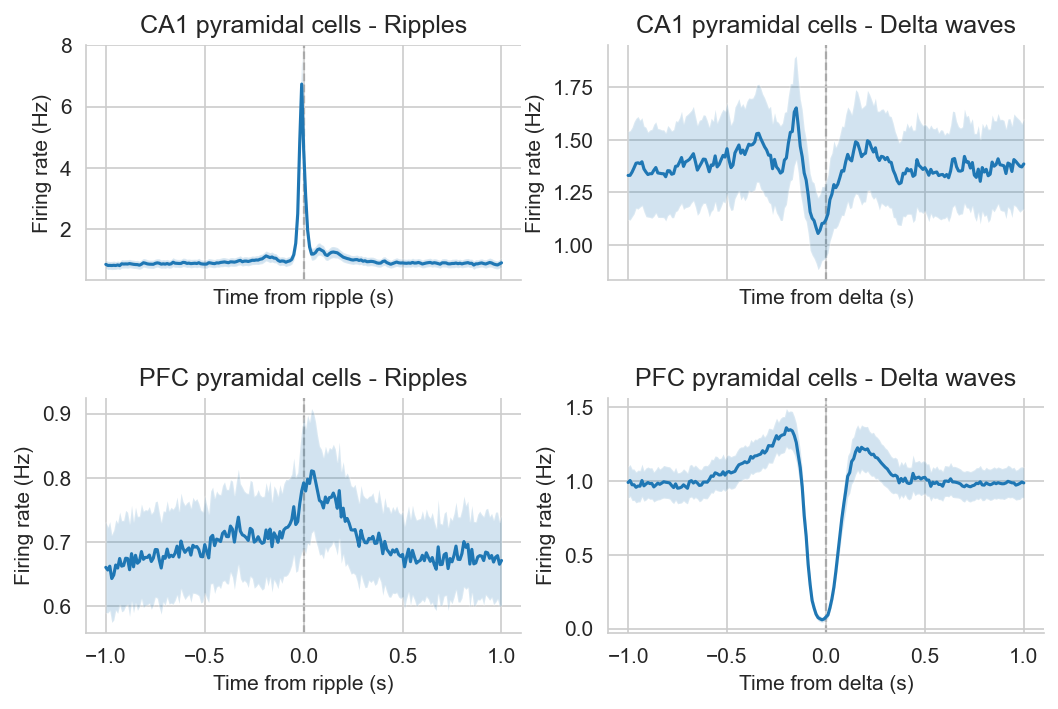

In [4]:
# restrict spike trains to NREM epochs only for state-specific analysis
st_nrem = st[sleep_states["NREMstate"]]

# Compute PETH for CA1 pyramidal cells aligned to ripples
# Input: spike trains for CA1 units, ripple event times
# Output: PETH matrix (time × unit) with smoothed firing rates and SEM
peth_st_swr_ca1 = peth(
    st_nrem.iloc[:, ca1_idx],
    ripples_df.peaks.values,
    bin_width=bin_width,
    window=window,
)

# Compute PETH for CA1 pyramidal cells aligned to delta waves
peth_st_delta_ca1 = peth(
    st_nrem.iloc[:, ca1_idx],
    deltas.peaks.values,
    bin_width=bin_width,
    window=window,
)

# Compute PETH for PFC pyramidal cells aligned to ripples
peth_st_swr_pfc = peth(
    st_nrem.iloc[:, pfc_idx],
    ripples_df.peaks.values,
    bin_width=bin_width,
    window=window,
)

# Compute PETH for PFC pyramidal cells aligned to delta waves
peth_st_delta_pfc = peth(
    st_nrem.iloc[:, pfc_idx],
    deltas.peaks.values,
    bin_width=bin_width,
    window=window,
)

# Create 2×2 subplot grid: rows=regions (CA1, PFC), columns=event types (ripples, deltas)
fig, axes = plt.subplots(
    2,
    2,
    figsize=npy.plotting.set_size("paper", 1, subplots=(2, 2)),
    sharex=True,  # Share x-axis for easy comparison
    dpi=150,
)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

# Plot PETH results: plot_peth_fast() shows mean ± SEM
npy.plotting.plot_peth_fast(peth_st_swr_ca1, ax=axes[0, 0])
npy.plotting.plot_peth_fast(peth_st_delta_ca1, ax=axes[0, 1])
npy.plotting.plot_peth_fast(peth_st_swr_pfc, ax=axes[1, 0])
npy.plotting.plot_peth_fast(peth_st_delta_pfc, ax=axes[1, 1])

# Add vertical line at event time (t=0) for visual reference
for ax in axes.ravel():
    ax.axvline(0, color="k", ls="--", lw=1, zorder=-10)  # Event marker
    ax.set_ylabel("Firing rate (Hz)")

# Label axes by event type
axes[0, 0].set_xlabel("Time from ripple (s)")
axes[0, 1].set_xlabel("Time from delta (s)")
axes[1, 0].set_xlabel("Time from ripple (s)")
axes[1, 1].set_xlabel("Time from delta (s)")

# Label axes by brain region and event type
axes[0, 0].set_title("CA1 pyramidal cells - Ripples")
axes[0, 1].set_title("CA1 pyramidal cells - Delta waves")
axes[1, 0].set_title("PFC pyramidal cells - Ripples")
axes[1, 1].set_title("PFC pyramidal cells - Delta waves")

## Calculate PETH for Continuous Data

### Analysis Goals
Unlike spike trains (discrete events), continuous signals like LFP directly reflect the voltage dynamics of local neural populations. We compute event-triggered averages of LFP on three channels to visualize how local field potentials modulate around ripples and delta waves.

**Channels analyzed:**
1. **Ripple channel (261)**: CA1 pyramidal layer—site of ripple generation
2. **Sharp wave channel (282)**: CA1 region—source of sharp-wave component
3. **Delta channel (53)**: PFC channel with delta oscillations

**Why NREM sleep?** Both ripples and delta waves occur preferentially during NREM sleep. Restricting analysis to NREM ensures we examine the same behavioral state across both event types, controlling for state-dependent changes in LFP amplitude.

### Method
For each channel, we average the continuous LFP signal across all ripple events (or delta events) and plot mean ± SEM. Sharp voltage deflections at t=0 indicate synchronization of the underlying neural population to the event.

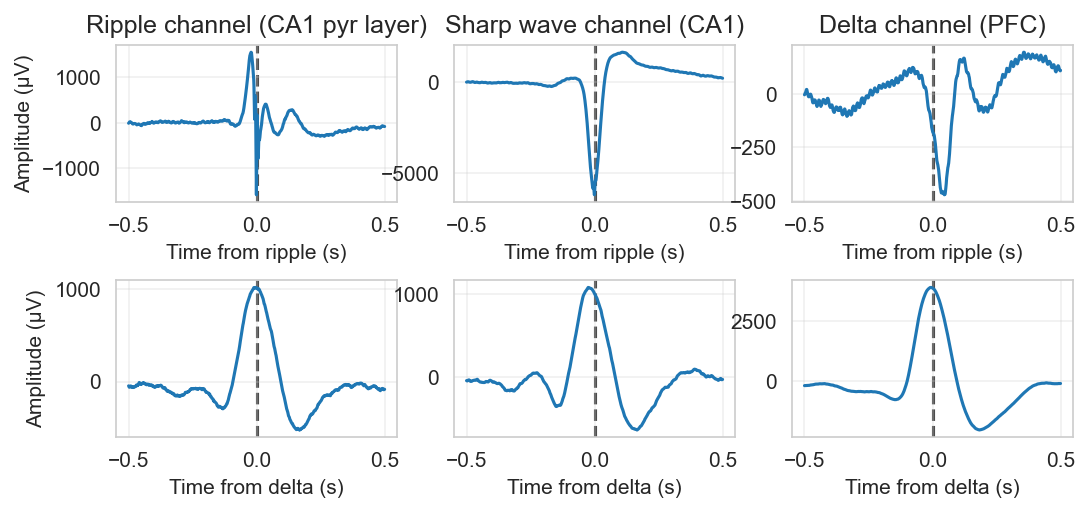

In [5]:
# Restrict LFP analysis to NREM sleep epochs only
# Sleep states have state-dependent effects on spike rates and LFP oscillations
# NREM is standardized across animals, enabling clean signal averaging
lfp_idx = npy.process.in_intervals(ts, sleep_states["NREMstate"].data)

# Create AnalogSignalArray with three channels of interest
# data shape after selection: (3 channels, nTimepoints_in_NREM)
# when we index lfp, we load lfp into memory
lfp_asa = nel.AnalogSignalArray(
    data=lfp[lfp_idx, :][:, [ripple_channel, sharp_wave_channel, delta_channel]].T,
    abscissa_vals=ts[lfp_idx],  # Time vector aligned to selected epochs
)

# Compute event-triggered averages of LFP around ripples
# Window = [-0.5, 0.5] sec provides finer temporal resolution for fast LFP dynamics
# bin_width = 1/1250 sec = 0.8 ms (matched to LFP sampling rate)
peth_lfp_swr = peth(
    lfp_asa, ripples_df.peaks.values, bin_width=1 / 1250, window=[-0.5, 0.5]
)

# Compute event-triggered averages of LFP around delta waves
peth_lfp_delta = peth(
    lfp_asa, deltas.peaks.values, bin_width=1 / 1250, window=[-0.5, 0.5]
)

# Create 2×3 subplot grid: rows=event type (ripples, deltas), columns=channels (ripple, sharp wave, delta)
fig, axes = plt.subplots(
    2, 3, figsize=npy.plotting.set_size("paper", 1, subplots=(2, 3)), dpi=150
)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes = axes.ravel()

# Top row: LFP modulation during ripple events
peth_lfp_swr.iloc[:, 0].plot(ax=axes[0])
peth_lfp_swr.iloc[:, 1].plot(ax=axes[1])
peth_lfp_swr.iloc[:, 2].plot(ax=axes[2])

# Bottom row: LFP modulation during delta wave events
peth_lfp_delta.iloc[:, 0].plot(ax=axes[3])
peth_lfp_delta.iloc[:, 1].plot(ax=axes[4])
peth_lfp_delta.iloc[:, 2].plot(ax=axes[5])

# Label columns by channel (top row titles)
axes[0].set_title("Ripple channel (CA1 pyr layer)")
axes[1].set_title("Sharp wave channel (CA1)")
axes[2].set_title("Delta channel (PFC)")

# Label rows by event type (left column x-labels)
axes[0].set_xlabel("Time from ripple (s)")
axes[1].set_xlabel("Time from ripple (s)")
axes[2].set_xlabel("Time from ripple (s)")

axes[3].set_xlabel("Time from delta (s)")
axes[4].set_xlabel("Time from delta (s)")
axes[5].set_xlabel("Time from delta (s)")

# Label y-axes
axes[0].set_ylabel("Amplitude (μV)")
axes[3].set_ylabel("Amplitude (μV)")

# Add event marker line at t=0 to each plot
for ax_ in axes:
    ax_.axvline(
        0, color="k", ls="--", lw=1.5, alpha=0.7, zorder=-10
    )  # Event onset marker
    ax_.grid(True, alpha=0.3)